# Final Project Submission

Please fill out:
* Student name: Collin Loo
* Student pace: part time
* Scheduled project review date/time: 8/13/20
* Instructor name: James M Irving, Ph.D.
* Blog post URL: https://medium.com/@collinloo/plotting-a-residual-qq-plot-from-scratch-2de4cab551ff
***

## Project Approach
The purpose of this project is to leverage linear regression to help not only home sellers to identify features that will boost home prices but also to guide home buyers to determine whether a house is over or  under valued based on its features.

The model will be built following the OSEMIN framework.  The framework provides guidelines to working on data problems using these five steps Obtain, Scrub, Explore, Model, and iNterpre.

After the initial fitting of the model, We will investigate ways to improve the $R^{2}$ by adding or removing features from the model as well as to develop an alternate model.  The final objective is to produce a model with a minimum $R^{2}$ of greater than or equal to 0.60.
***

## Obtain data

### Import Data

In [1]:
# Import various libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn import preprocessing
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import myFunc as myf
%matplotlib inline


In [2]:
# Import data uisng pandas
d = pd.read_csv("csv_files/kc_house_data.csv")
pd.set_option('display.max_columns', None)

# Preview data
d.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


***

##  Scrub and Clean Data

### Inspect Columns in the Dataframe

In [3]:
# Inspect the columns to identify mis-cast data type as well as spotting possible categorical data
d.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


### Inspect Column Unique Values

In [4]:
# Investigate number of unique values in each column to get a better idea as to which
# features should be treated as categorical
for col in d.columns:
    try:
        print(d[col].value_counts()[:5])
    except:
        print(d[col].value_counts())
    print(f'{col} with number of unique values: {d[col].nunique()}')
    print('\n')


795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
Name: id, dtype: int64
id with number of unique values: 21420


6/23/2014    142
6/25/2014    131
6/26/2014    131
7/8/2014     127
4/27/2015    126
Name: date, dtype: int64
date with number of unique values: 372


350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
           ... 
870515.0      1
336950.0      1
386100.0      1
176250.0      1
884744.0      1
Name: price, Length: 3622, dtype: int64
price with number of unique values: 3622


3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64
bedrooms with number of unique values: 12


2.50    5377
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      71
4.75      23
5.00      21
Name: bathrooms, dtype: int64
bathrooms with number of unique values: 29


1300    138
1400    135
144

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Sqft_basement has the object data type.</li>
        <li>Sqft_basement column contains character "?", which will need to be replaced.</li>
        <li>Id can be dropped from the dataset since it doesn't provide any useful information to the model.</li>
        <li>Date, waterfront, view, yr_build, yr_renovated  can be treated as category.</li>
        <li>Bedroom, bathrooms, floors, condition, grade are also good categorical candidates.</li>
    </ul>
</div>

In [5]:
# Replace '?' in sqft_basement and change the data type to int64
d.sqft_basement = d.sqft_basement.map(lambda x: x.replace('?','0.0'))
d.sqft_basement = d.sqft_basement.map(lambda x: int(x.replace('.0','')))

# Confirm changes
print(d['sqft_basement'].dtypes)


int64


In [6]:
# Drop the id column from the dataset since it is irrelevant to the model
d.drop(columns=['id'], axis=1, inplace=True)

# Confirm changes
d.columns


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Check Null Values

In [7]:
# Checking for null values
d.isna().sum()


date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [8]:
# Replace null values in waterfront, view, yr_renovated with their most common values.
for col in ['waterfront', 'view', 'yr_renovated']:
    d[col].fillna(0, inplace=True)

# confirm changes
d.isna().sum()


date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Categorical Data

#### Examine Features vs Price 

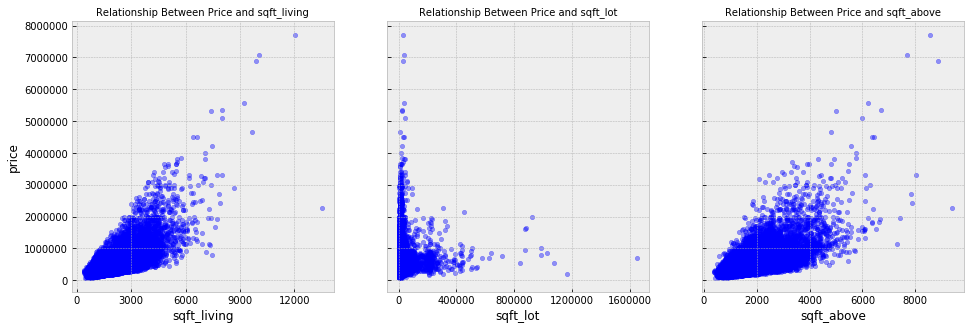

In [9]:
# Inspect data distribution
with plt.style.context('bmh'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)
    for xcol, ax in zip(['sqft_living', 'sqft_lot', 'sqft_above'], axes):
        d.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='blue')
        ax.set_title(f'Relationship Between Price and {xcol}', size=10)
    for ax in axes:
        # set the spacing of major ticker
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
   

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>    
        <li>Sqft_living displays a linear relationship with price.  Data contain outliers.</li>
        <li>Sqft_lot shows a slight linear relationship with price.  Data are heavily skewed with a right long tail.</li>
        <li>Sqft_above shows linearity with price and it also contains outliers.  The data distribution look very similar to sqft_living because they are correlated.</li>
    </ul>
</div>

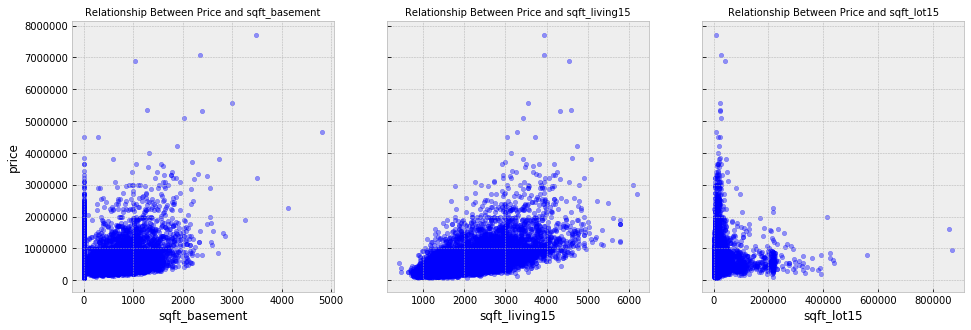

In [10]:
# Inspect data distribution
with plt.style.context('bmh'):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,5), sharey=True)
    for xcol, ax in zip(['sqft_basement', 'sqft_living15', 'sqft_lot15'], axes):
        d.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='blue')
        ax.set_title(f'Relationship Between Price and {xcol}', size=10)
        

<div class="alert alert-block alert-info">
<b>Observations</b>
<ul>
    <li>Sqft_basement has a linear relationship with price.  It has outliers on both end of the tails.</li>
    <li>Sqft_living15 shows a linear relationship with price and it also contains outliers.</li>
    <li>Sqft_lot15 displays similar data distribution as sqft_lot as they are correlated.</li>
</ul>
</div>

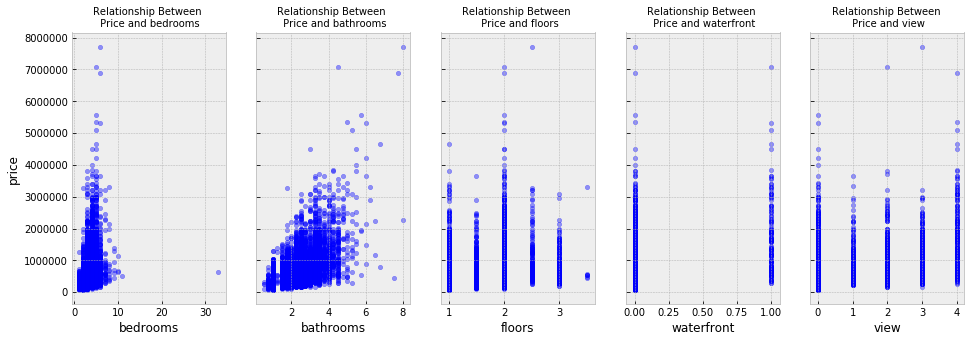

In [11]:
# Inspect data distribution
with plt.style.context('bmh'):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,5), sharey=True)
    for xcol, ax in zip(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view'], axes):
        d.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='blue')
        ax.set_title(f'Relationship Between \n Price and {xcol}', size=10)
        

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>All five plots show data stacking in a vertical direction. They are clearly categorical data type.</li>
    </ul>
</div>

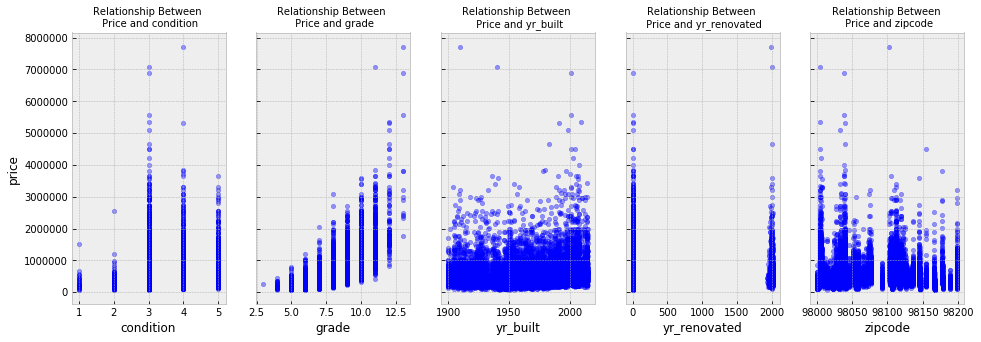

In [12]:
with plt.style.context('bmh'):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,5), sharey=True)
    for xcol, ax in zip(['condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode'], axes):
        d.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='blue')
        ax.set_title(f'Relationship Between \n Price and {xcol}', size=10)
        

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>These five plots show same behaviors as the plots above them,  data stacking in a vertical direction. They can be treated as categorical data type.</li>
    </ul>
</div>

#### Categorical Data Type Treatments

In [13]:
# Create a new dataframe and a column to map zip codes to cities
# kc_citeis_zipcode data were gather from the internet.
# source: https://www.zip-codes.com/county/wa-king.asp
# data were cleaned up in Excel and exported as csv file 
cities = pd.read_csv('csv_files/kc_cities_zipcode.csv')
df = pd.merge(d, cities, on='zipcode')

# Verify updates
print(len(df), len(d))
print(df.price.mean(), d.price.mean())


21597 21597
540296.5735055795 540296.5735055795


In [14]:
# Change features to either/or category by converting value greater than zero to one
df['waterfront'] = df.waterfront.map(lambda x: 1 if x > 0 else 0)
df['view'] = df.view.map(lambda x: 1 if x > 0 else 0)
df['yr_renovated'] = df.yr_renovated.map(lambda x: 1 if x > 0 else 0)
df['sqft_basement'] = df.sqft_basement.map(lambda x: 1 if x > 0 else 0)

# Group house built year into a 20-year interval
df['age'] = df.yr_built.map(lambda x: myf.gp_yr_built(x))


In [15]:
# Convert categorical data cast as interger to object type 
# Nom_cat contains columns for one-hot encoding processing later
nom_cat = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',  
           'grade', 'yr_renovated', 'age', 'city', 'condition', 'sqft_basement']
old_cat = []
for col in nom_cat:
    df[col] = df[col].astype('object')
    old_cat.append(f'{col} dtype: {df[col].dtype}')

# Confirm changes
print(old_cat)


['bedrooms dtype: object', 'bathrooms dtype: object', 'floors dtype: object', 'waterfront dtype: object', 'view dtype: object', 'grade dtype: object', 'yr_renovated dtype: object', 'age dtype: object', 'city dtype: object', 'condition dtype: object', 'sqft_basement dtype: object']


***

## Explore Data

### Objectives:  Attempt to answer the following three questions during the EDA stage.
* How are data distributed at the high-level?&emsp;&emsp;<span style="color:green">Answered in section 1.4.2</span>
* Where are the outliers?&emsp;&emsp;<span style="color:green">Answered in section 1.4.3</span>
* Are there any correlation and multicollinearity among the features?&emsp;&emsp;<span style="color:green">Answered in section 1.4.4</span>

### Descriptive Analysis - (How are data distributed at the high-level?)

In [16]:
# Quick overview of the data descriptive statistics
df.describe()

,price,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,2080.321850,1.509941e+04,1788.596842,1970.999676,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,918.106125,4.141264e+04,827.759761,29.375234,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,370.000000,5.200000e+02,370.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,1430.000000,5.040000e+03,1190.000000,1951.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,1910.000000,7.618000e+03,1560.000000,1975.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,2550.000000,1.068500e+04,2210.000000,1997.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,13540.000000,1.651359e+06,9410.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Price contains extreme outliers.  So are sqft_above, sqft_basement, sqft_living, and sqft_lot.  Since they are linearly correlated to price, once we remove the outliers in the price column, outliers in the other 4 columns will be removed as well.</li>
        <li>75% of the houses were built after 1950 and not many new houses were built after 2010 .</li>
        <li>50 % of the houses are in average condition, according to the condition and grade mean values.</li>
        <li>Big variance in price and sqft_living for the houses in King County.  This could be due to extreme outliers.</li>
    </ul>
</div>

### Examine Outliers - (Where are the outliers?)

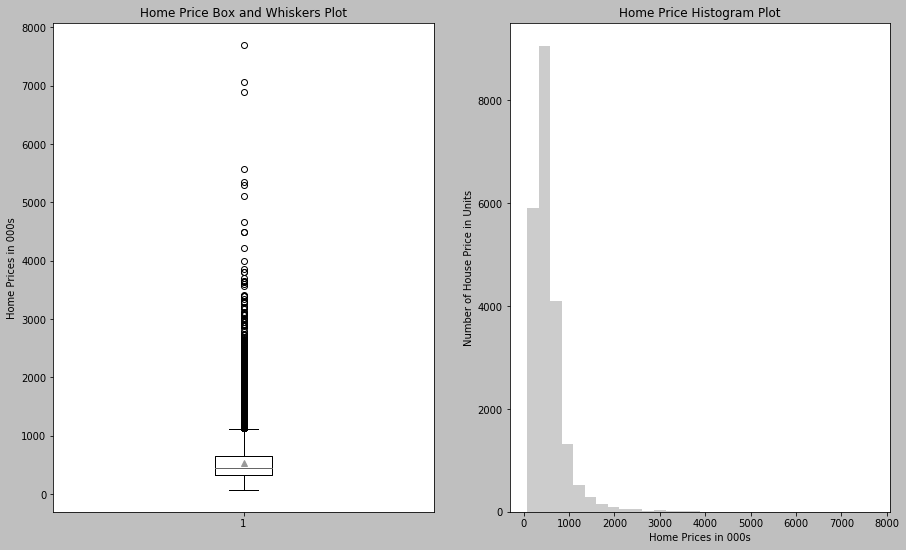

In [17]:
# Investigate outliers in home prices
with plt.style.context('grayscale'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
    ax1.boxplot(df.price/1000, showmeans=True)
    ax1.set_ylabel('Home Prices in 000s')
    ax1.set_title('Home Price Box and Whiskers Plot')
    ax2.hist(df.price/1000, bins=30, alpha=0.2)
    ax2.set_ylabel('Number of House Price in Units')
    ax2.set_xlabel('Home Prices in 000s')
    ax2.set_title('Home Price Histogram Plot')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Extreme outliers in house prices occur after the 3.7 million mark.</li>
        <li>Mean in the box-plot is more than the median, which suggests that the data are positively skewed with a long right tail as evidenced by the histogram plotted on the right.</li>
    </ul>
</div>

In [18]:
# Finding a cutoff point to remove the outliers in order to subset the data
for i in range(90, 100):
    q = i / 100
    print('{} percentile: {}'.format(q, df['price'].quantile(q=q)))

0.9 percentile: 887000.0
0.91 percentile: 919993.6
0.92 percentile: 950000.0
0.93 percentile: 997964.0000000002
0.94 percentile: 1060000.0
0.95 percentile: 1160000.0
0.96 percentile: 1260000.0
0.97 percentile: 1390000.0
0.98 percentile: 1600000.0
0.99 percentile: 1970000.0


Percent of data removed: 1.00% 



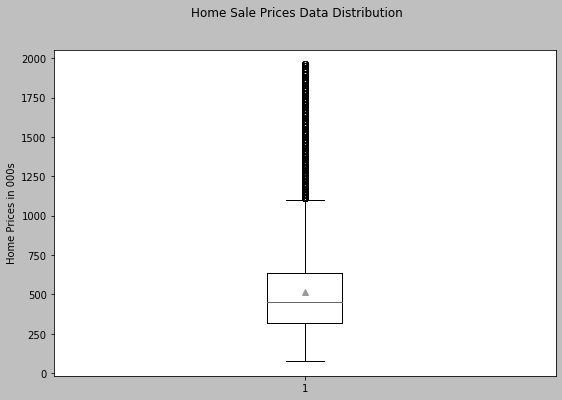

In [19]:
# Try with cutoff at 99% quantile for the initial model fitting
df_subset = df[df['price'] < 1970000]
print(f'Percent of data removed: {"{:.2%}".format((len(df) - len(df_subset))/len(df))} \n')

with plt.style.context('grayscale'):
    plt.figure(figsize=(9,6))
    plt.boxplot(df_subset.price/1000, showmeans=True)
    plt.suptitle('Home Sale Prices Data Distribution')
    plt.ylabel('Home Prices in 000s')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are still outliers in the data after removing the extremes.</li>
        <li>We will revisit this issue after the initial model fitting.</li>
    </ul>
</div>

### Check correlation and covariance - (Are there any correlation and multicollinearity among the features?)

In [20]:
# Generate a pair-wise correlation matrix
display(df_subset.iloc[:,2:].corr())

# Highlight True items
(df_subset.iloc[:,2:].corr() > .75).style.applymap(myf.color_true_red)


,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
sqft_living,1.000000,0.175440,0.867559,0.338997,-0.204762,0.041677,0.263107,0.754853,0.185815
sqft_lot,0.175440,1.000000,0.184498,0.051817,-0.131171,-0.087774,0.229421,0.146153,0.713360
sqft_above,0.867559,0.184498,1.000000,0.443685,-0.267224,-0.013061,0.366781,0.727922,0.194759
yr_built,0.338997,0.051817,0.443685,1.000000,-0.345734,-0.149371,0.410749,0.338407,0.069471
zipcode,-0.204762,-0.131171,-0.267224,-0.345734,1.000000,0.268990,-0.564807,-0.281858,-0.147986
lat,0.041677,-0.087774,-0.013061,-0.149371,0.268990,1.000000,-0.134431,0.041585,-0.087800
long,0.263107,0.229421,0.366781,0.410749,-0.564807,-0.134431,1.000000,0.349431,0.254746
sqft_living15,0.754853,0.146153,0.727922,0.338407,-0.281858,0.041585,0.349431,1.000000,0.183910
sqft_lot15,0.185815,0.713360,0.194759,0.069471,-0.147986,-0.087800,0.254746,0.183910,1.000000


,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
sqft_living,True,False,True,False,False,False,False,True,False
sqft_lot,False,True,False,False,False,False,False,False,False
sqft_above,True,False,True,False,False,False,False,False,False
yr_built,False,False,False,True,False,False,False,False,False
zipcode,False,False,False,False,True,False,False,False,False
lat,False,False,False,False,False,True,False,False,False
long,False,False,False,False,False,False,True,False,False
sqft_living15,True,False,False,False,False,False,False,True,False
sqft_lot15,False,False,False,False,False,False,False,False,True


In [21]:
# Condensed the above correlation matrix for easy visualization

# Save absolute value of correlation matrix as a dataframe
# Stack the row:column pairs into a multiindex
# Reset the index to set the multindex to sepaerate columns
# Sort values. 0 is the column automatically generated by the stacking
df_cor = df_subset.iloc[:,2:].corr().abs().stack().reset_index().sort_values(0, ascending=False)

# Zip the variable name columns into a new column
df_cor['pairs'] = list(zip(df_cor.level_0, df_cor.level_1))

# Set index to pairs
df_cor.set_index(['pairs'], inplace=True)

# Drop level_0 & 1 columns
df_cor.drop(columns=['level_0', 'level_1'], inplace=True)

# Rename correleation column from 0 to cc
df_cor.columns = ['cor']

# Drop duplicates
df_cor.drop_duplicates(inplace=True)

df_cor[(df_cor.cor > .75) & (df_cor.cor < 1)]


,cor
pairs,
"(sqft_living, sqft_above)",0.867559
"(sqft_living, sqft_living15)",0.754853


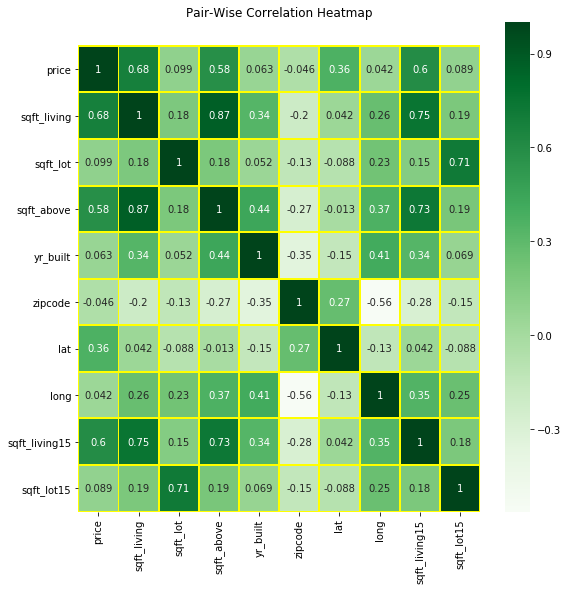

In [22]:
# A graphical representation of the pair-wise correlation using heatmap
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(df_subset.iloc[:,].corr(), cmap='Greens', annot=True, linewidths=1, linecolor='yellow')
ax.set_ylim(len(df_subset.iloc[:,:].corr())-0, -0.5)
ax.set_title("Pair-Wise Correlation Heatmap")
plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Sqft_above, sqft_living15 features show a strong correlation with sqft_living.</li>
        <li>Sqft_lot vs sqft_lot15 though did not make the cut off (0.71), we should investigate this feature during the multicollinearity assumption check.</li>
        <li>Sqft_living demonstrates the strongest correlation with price.</li>
    </ul>
</div>

### One-Hot Category Encoding

In [23]:
# Perform one-hot encoding on categorical data
dummies = pd.get_dummies(df_subset[nom_cat], prefix=nom_cat, drop_first=True)

# Create a dataframe, dropping nominal feature columns
df_subset_cat = df_subset.drop(nom_cat, axis=1)

# Concat the above two dataframes
df_subset_cat = pd.concat([df_subset_cat, dummies], axis=1)

# Preview the results
df_subset_cat.head()


,date,price,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,view_1,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,yr_renovated_1,age_2,age_3,age_4,age_5,city_Bellevue,city_Black Diamond,city_Bothell,city_Carnation,city_Duvall,city_Enumclaw,city_Fall City,city_Federal Way,city_Issaquah,city_Kenmore,city_Kirkland,city_Maple Valley,city_Medina,city_Mercer Island,city_North Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,condition_2,condition_3,condition_4,condition_5,sqft_basement_1
0,10/13/2014,221900.0,1180,5650,1180,1955,98178,47.5112,-122.257,1340,5650,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,6/23/2014,205425.0,880,6780,880,1945,98178,47.5009,-122.248,1190,6780,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,7/17/2014,445000.0,2100,8201,1620,1967,98178,47.5091,-122.244,2660,8712,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
3,9/25/2014,236000.0,1300,5898,1300,1961,98178,47.5053,-122.255,1320,7619,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,2/27/2015,170000.0,860,5265,860,1931,98178,47.5048,-122.272,1650,8775,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


### Perform Train-Test-Split

In [24]:
# Create train-test dataset for model validation later
train, test = train_test_split(df_subset_cat, test_size=0.2, random_state=36)

# Check datasets
print(train.shape, test.shape)


(17104, 96) (4276, 96)


***

## Model Data

### Define features to Exclude

In [25]:
# Create a list of features to be excluded for the model evaluation

# Exclude date because too many unique values.  May include in refinement if necessary
# Exclude sqft_lot and sqft_lot15 because they lack a linear relationship with the target
# Exclude sqft_above and sqft_living15 because they show strong correlation with sqft_living
# Exclude yr_built because we replaced it with the 'age' column
# Exclude zipcode becasue we map new column 'cities' to zip code


fea_excl = ['date', 'price', 'sqft_lot', 'sqft_above', 'yr_built', 'zipcode',
            'lat', 'long', 'sqft_living15', 'sqft_lot15']          


In [26]:
# Clean up columns names
train.columns = [col.replace('.', '_') for col in train.columns]
train.columns = [col.replace(' ', '_') for col in train.columns]

# Define the problem
outcome = 'price'

# Create the feature list
x_cols = list(train.columns)

# Remove unwated features
for col in fea_excl:
    x_cols.remove(col)


### Construct the Initial Model - Model A

#### Initial Model Fitting

In [27]:
# Model fitting
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     619.8
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:39   Log-Likelihood:            -2.2708e+05
No. Observations:               17104   AIC:                         4.543e+05
Df Residuals:                   17018   BIC:                         4.550e+05
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.441e+05   1.78e+05     -0.809      0.418   -4.93e+05    2.05e+05
sqft_living          112.9614      2.691     41.985      0.000     107.688     118.235
bedrooms_2          7222.4158   1.21e+04      0.598      0.550   -1.64e+04    3.09e+04
bedrooms_3          3834.0304   1.21e+04      0.317      0.751   -1.99e+04    2.75e+04
bedrooms_4         -6534.2983   1.24e+04     -0.529      0.597   -3.07e+04    1.77e+04
bedrooms_5         -2.658e+04    1.3e+04     -2.040      0.041   -5.21e+04   -1035.866
bedrooms_6         -4.655e+04   1.61e+04     -2.898      0.004    -7.8e+04   -1.51e+04
bedrooms_7         -9.608e+04    3.2e+04     -3.002      0.003   -1.59e+05   -3.34e+04
bedrooms_8          4533.8318   4.68e+04      0.097      0.923   -8.72e+04    9.63e+04
bedrooms_9          5.832e+04   7.26e+04      0.803      0.422    -8.4e+04    2.01e+05
bedrooms_10        -1.202e+05   8.44e+04     -1.425      0.154   -2.86e+05    4.52e+04
bedrooms_11        -2.366e+05   1.42e+05     -1.663      0.096   -5.16e+05    4.23e+04
bedrooms_33         1.632e+05   1.42e+05      1.148      0.251   -1.15e+05    4.42e+05
bathrooms_0_75      5.418e+04   1.02e+05      0.530      0.596   -1.46e+05    2.55e+05
bathrooms_1_0       7.212e+04      1e+05      0.719      0.472   -1.24e+05    2.69e+05
bathrooms_1_25      1.936e+05   1.23e+05      1.576      0.115   -4.72e+04    4.34e+05
bathrooms_1_5       7.084e+04      1e+05      0.706      0.481   -1.26e+05    2.68e+05
bathrooms_1_75      7.543e+04      1e+05      0.752      0.452   -1.21e+05    2.72e+05
bathrooms_2_0        7.51e+04      1e+05      0.748      0.454   -1.22e+05    2.72e+05
bathrooms_2_25      8.819e+04      1e+05      0.878      0.380   -1.09e+05    2.85e+05
bathrooms_2_5       7.266e+04      1e+05      0.724      0.469   -1.24e+05    2.69e+05
bathrooms_2_75      9.255e+04      1e+05      0.921      0.357   -1.04e+05     2.9e+05
bathrooms_3_0       9.629e+04   1.01e+05      0.958      0.338   -1.01e+05    2.93e+05
bathrooms_3_25      1.452e+05   1.01e+05      1.442      0.149   -5.21e+04    3.42e+05
bathrooms_3_5       1.186e+05   1.01e+05      1.178      0.239   -7.87e+04    3.16e+05
bathrooms_3_75      1.967e+05   1.01e+05      1.940      0.052   -1992.001    3.95e+05
bathrooms_4_0       1.503e+05   1.02e+05      1.480      0.139   -4.88e+04    3.49e+05
bathrooms_4_25      1.649e+05   1.03e+05      1.608      0.108   -3.62e+04    3.66e+05
bathrooms_4_5       1.453e+05   1.02e+05      1.424      0.154   -5.47e+04    3.45e+05
bathrooms_4_75      2.376e+05   1.14e+05      2.082      0.037    1.39e+04    4.61e+05
bathrooms_5_0        2.35e+05   1.08e+05      2.174      0.030    2.32e+04    4.47e+05
bathrooms_5_25      1.879e+05   1.12e+05      1.684      0.092   -3.08e+04    4.07e+05
bathrooms_5_5       1.914e+04    1.3e+

#### Remove P-Value > 0.05 (I)

In [28]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()


No. of col before: 87. after: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     959.6
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:39   Log-Likelihood:            -2.2821e+05
No. Observations:               17104   AIC:                         4.565e+05
Df Residuals:                   17057   BIC:                         4.569e+05
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.121e+05   3.51e+04     -6.043      0.000   -2.81e+05   -1.43e+05
sqft_living          178.3551      1.822     97.864      0.000     174.783     181.927
bedrooms_5         -3.705e+04   4731.651     -7.830      0.000   -4.63e+04   -2.78e+04
bedrooms_6         -7.617e+04   1.08e+04     -7.051      0.000   -9.73e+04    -5.5e+04
bedrooms_7         -1.405e+05    3.1e+04     -4.536      0.000   -2.01e+05   -7.98e+04
bathrooms_4_75      6.912e+04   5.77e+04      1.198      0.231    -4.4e+04    1.82e+05
bathrooms_5_0       6.959e+04   4.22e+04      1.647      0.100   -1.32e+04    1.52e+05
bathrooms_6_0       -7.34e+05    1.1e+05     -6.700      0.000   -9.49e+05   -5.19e+05
bathrooms_6_75     -8.936e+05   1.54e+05     -5.784      0.000    -1.2e+06   -5.91e+05
floors_1_5         -1868.6432   4503.946     -0.415      0.678   -1.07e+04    6959.554
floors_2_5          1.003e+05   1.43e+04      7.032      0.000    7.24e+04    1.28e+05
floors_3_0          8.487e+04   7076.449     11.993      0.000     7.1e+04    9.87e+04
waterfront_1        3.498e+05   1.72e+04     20.331      0.000    3.16e+05    3.84e+05
view_1              1.064e+05   4287.340     24.825      0.000     9.8e+04    1.15e+05
grade_10            1.637e+05   5942.338     27.543      0.000    1.52e+05    1.75e+05
grade_11            2.537e+05   1.02e+04     24.755      0.000    2.34e+05    2.74e+05
grade_12            4.235e+05   2.39e+04     17.733      0.000    3.77e+05     4.7e+05
grade_13            8.944e+05   1.51e+05      5.917      0.000    5.98e+05    1.19e+06
yr_renovated_1      6.047e+04   6667.494      9.070      0.000    4.74e+04    7.35e+04
age_2              -8885.6445   3371.906     -2.635      0.008   -1.55e+04   -2276.361
age_3              -3.438e+04   3342.511    -10.286      0.000   -4.09e+04   -2.78e+04
age_4               8.461e+04   4895.960     17.282      0.000     7.5e+04    9.42e+04
age_5               9.973e+04   5192.168     19.207      0.000    8.95e+04     1.1e+05
city_Bellevue       3.765e+05   6124.385     61.474      0.000    3.64e+05    3.88e+05
city_Black_Diamond  6.858e+04   1.71e+04      4.002      0.000     3.5e+04    1.02e+05
city_Bothell        1.491e+05   8659.733     17.214      0.000    1.32e+05    1.66e+05
city_Carnation      1.094e+05   1.61e+04      6.804      0.000    7.79e+04    1.41e+05
city_Duvall         1.039e+05    1.3e+04      7.988      0.000    7.84e+04    1.29e+05
city_Fall_City      1.808e+05    1.9e+04      9.513      0.000    1.44e+05    2.18e+05
city_Issaquah       2.161e+05   6509.291     33.193      0.000    2.03e+05    2.29e+05
city_Kenmore        1.859e+04   6229.851      2.984      0.003    6378.766    3.08e+04
city_Kirkland       2.087e+05   8369.471     24.933      0.000    1.92e+05    2.25e+05
city_Maple_Valley   4.397e+04   7893.2

#### Remove P-Value > 0.05 (II)

In [29]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()


No. of col before: 47. after: 43


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1026.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:39   Log-Likelihood:            -2.2821e+05
No. Observations:               17104   AIC:                         4.565e+05
Df Residuals:                   17060   BIC:                         4.569e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.122e+05   3.51e+04     -6.045      0.000   -2.81e+05   -1.43e+05
sqft_living          178.4339      1.820     98.023      0.000     174.866     182.002
bedrooms_5         -3.697e+04   4729.809     -7.817      0.000   -4.62e+04   -2.77e+04
bedrooms_6         -7.473e+04   1.08e+04     -6.935      0.000   -9.59e+04   -5.36e+04
bedrooms_7         -1.408e+05    3.1e+04     -4.544      0.000   -2.02e+05   -8.01e+04
bathrooms_6_0      -7.374e+05    1.1e+05     -6.733      0.000   -9.52e+05   -5.23e+05
bathrooms_6_75     -8.955e+05   1.54e+05     -5.797      0.000    -1.2e+06   -5.93e+05
floors_2_5           1.01e+05   1.42e+04      7.092      0.000    7.31e+04    1.29e+05
floors_3_0          8.492e+04   7072.510     12.007      0.000    7.11e+04    9.88e+04
waterfront_1        3.497e+05   1.72e+04     20.321      0.000    3.16e+05    3.83e+05
view_1              1.064e+05   4286.219     24.831      0.000     9.8e+04    1.15e+05
grade_10            1.639e+05   5939.757     27.601      0.000    1.52e+05    1.76e+05
grade_11            2.556e+05   1.02e+04     25.041      0.000    2.36e+05    2.76e+05
grade_12            4.265e+05   2.37e+04     17.969      0.000     3.8e+05    4.73e+05
grade_13            8.942e+05   1.51e+05      5.915      0.000    5.98e+05    1.19e+06
yr_renovated_1      6.046e+04   6664.251      9.073      0.000    4.74e+04    7.35e+04
age_2              -8893.8124   3371.308     -2.638      0.008   -1.55e+04   -2285.701
age_3               -3.44e+04   3342.286    -10.293      0.000    -4.1e+04   -2.79e+04
age_4               8.402e+04   4683.456     17.939      0.000    7.48e+04    9.32e+04
age_5               9.911e+04   4991.446     19.855      0.000    8.93e+04    1.09e+05
city_Bellevue       3.765e+05   6123.776     61.487      0.000    3.65e+05    3.89e+05
city_Black_Diamond  6.838e+04   1.71e+04      3.991      0.000    3.48e+04    1.02e+05
city_Bothell        1.493e+05   8657.924     17.240      0.000    1.32e+05    1.66e+05
city_Carnation      1.091e+05   1.61e+04      6.789      0.000    7.76e+04    1.41e+05
city_Duvall         1.038e+05    1.3e+04      7.983      0.000    7.83e+04    1.29e+05
city_Fall_City      1.818e+05    1.9e+04      9.565      0.000    1.45e+05    2.19e+05
city_Issaquah       2.161e+05   6508.948     33.193      0.000    2.03e+05    2.29e+05
city_Kenmore        1.875e+04   6229.322      3.010      0.003    6542.575     3.1e+04
city_Kirkland       2.086e+05   8369.579     24.925      0.000    1.92e+05    2.25e+05
city_Maple_Valley   4.426e+04   7891.796      5.608      0.000    2.88e+04    5.97e+04
city_Medina         9.853e+05   3.49e+04     28.226      0.000    9.17e+05    1.05e+06
city_Mercer_Island  5.223e+05   1.13e+04     46.301      0.000       5e+05    5.44e+05
city_North_Bend     1.277e+05    1.2e+

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>After reducing number of features from 87 to 43.  We see a drop in $R^{2}$ from 0.756 to 0.721.</li>
        <li>The skew value of 1.235 suggests that the distribution is highly skewed.</li>
        <li>The kurtosis value of 8.889 indicates that the distribution has a heavy tails.</li>
    </ul>
</div>

### Multicollinearity Check

In [30]:
# Investigate multicollinearity
x_cols, vif = myf.cal_vif(train, x_cols, variance_inflation_factor)
list(zip(x_cols, vif))


[('sqft_living', 12.325248272155955),
 ('bedrooms_5', 1.216797059261703),
 ('bedrooms_6', 1.059006055209357),
 ('bedrooms_7', 1.0527524579076883),
 ('bathrooms_6_0', 1.0522019667628584),
 ('bathrooms_6_75', 1.0466408795506432),
 ('floors_2_5', 1.0227880924151922),
 ('floors_3_0', 1.114405656126959),
 ('waterfront_1', 1.0901635821840454),
 ('view_1', 1.2930666349717714),
 ('grade_10', 1.3373570268194632),
 ('grade_11', 1.201276061074278),
 ('grade_12', 1.111496190938862),
 ('grade_13', 1.0021632248602912),
 ('yr_renovated_1', 1.1059472038375897),
 ('age_2', 1.7812866328475643),
 ('age_3', 1.9051185473339254),
 ('age_4', 1.3459645900594113),
 ('age_5', 1.3261560957855645),
 ('city_Bellevue', 1.7653314022984468),
 ('city_Black_Diamond', 1.0549972444429703),
 ('city_Bothell', 1.2500631438948557),
 ('city_Carnation', 1.0637625902949448),
 ('city_Duvall', 1.1038668527524513),
 ('city_Fall_City', 1.044806650468024),
 ('city_Issaquah', 1.619389901704239),
 ('city_Kenmore', 1.614255229035968),


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Sqft_Living VIF indicates a strong presence of multicollinearity with other features.</li>
        <li>We will remove VIF greater than 10 in the model refinement process, with the exception to the sqft_living feature because of its strong correlation with the target variable, price.</li>  
    </ul>
</div>

### Normality Assumption Check

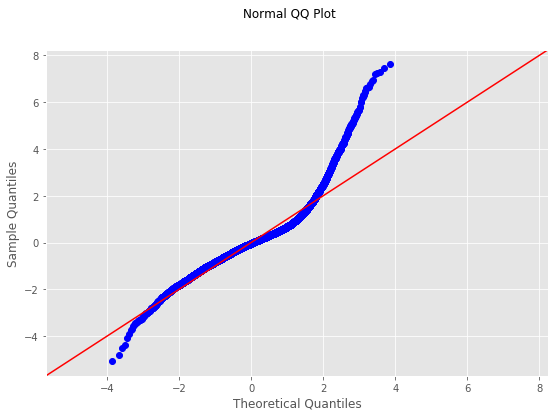

In [31]:
# Plot residual QQ Plot to check normality 
with plt.style.context('ggplot'):
    plt.rc("figure", figsize=(9,6))
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.suptitle("Normal QQ Plot")
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The residual QQ Plot reveals a strong presence of outliers in our dataset.</li>
        <li>The model does not perform well for data over the second quantile.</li>
        <li>The normality assumption for regression does not hold.</li>
    </ul>
<div>

### Homoscedasticity Assumption Check

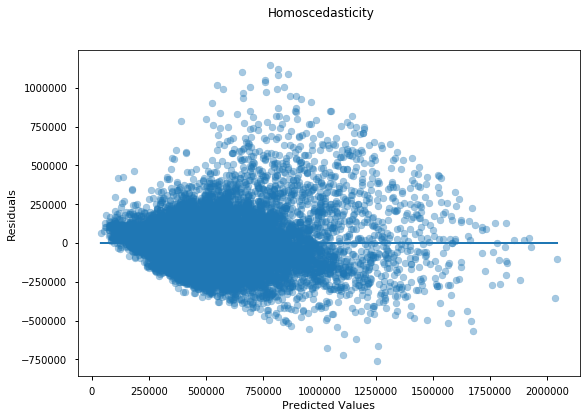

In [32]:
# Plot to show Homoscedasticity
with plt.style.context('seaborn-notebook'):
    plt.rc("figure", figsize=(9,6))
    plt.scatter(model.predict(train[x_cols]), model.resid, alpha=0.4)
    plt.plot(model.predict(train[x_cols]), [0 for i in range(len(train))])
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.suptitle('Homoscedasticity')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The plot shows no obvious cone shape pattern overall.  Homoscedasticity assumption holds.</li>
    </ul>
</div>

***

## Model Refinement I (Model A)

### Normallity Corrections - Remove Outliers

In [33]:
# Try with a cutoff at 95% quantile. during the initial fitting, the data
# was subset at 99% quantile
train_ss = train[train['price'] < 1160000]
print(f'Percent of data removed:{"{:.2%}".format((len(train) - len(train_ss))/len(train))} \n')


Percent of data removed:4.11% 



### Multicollinearity Corrections - Remove Features with High VIF

In [34]:
# Remove VIF that are greater than 10, except sqft_living
x_cols = myf.rem_large_vif(x_cols, vif, 10, np)
print(x_cols)
len(x_cols)


['sqft_living', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bathrooms_6_0', 'bathrooms_6_75', 'floors_2_5', 'floors_3_0', 'waterfront_1', 'view_1', 'grade_10', 'grade_11', 'grade_12', 'grade_13', 'yr_renovated_1', 'age_2', 'age_3', 'age_4', 'age_5', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Fall_City', 'city_Issaquah', 'city_Kenmore', 'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 'city_North_Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon', 'city_Woodinville', 'condition_2', 'condition_4', 'condition_5']


42

### Refit Model A with New Updates

#### Initial Model Run with New Updates

In [35]:
# Refit model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train_ss).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     867.9
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:43   Log-Likelihood:            -2.1486e+05
No. Observations:               16401   AIC:                         4.298e+05
Df Residuals:                   16359   BIC:                         4.301e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.733e+04   4476.339     -3.872      0.000   -2.61e+04   -8559.507
sqft_living          156.1445      1.507    103.591      0.000     153.190     159.099
bedrooms_5         -4.132e+04   3935.024    -10.501      0.000    -4.9e+04   -3.36e+04
bedrooms_6         -5.643e+04   8948.110     -6.306      0.000    -7.4e+04   -3.89e+04
bedrooms_7         -1.161e+05    2.6e+04     -4.468      0.000   -1.67e+05   -6.52e+04
bathrooms_6_0      -6.609e+05   1.45e+05     -4.548      0.000   -9.46e+05   -3.76e+05
bathrooms_6_75     -6.417e+05   1.22e+05     -5.265      0.000   -8.81e+05   -4.03e+05
floors_2_5          4.073e+04   1.26e+04      3.234      0.001     1.6e+04    6.54e+04
floors_3_0          7.288e+04   5725.548     12.729      0.000    6.17e+04    8.41e+04
waterfront_1        1.223e+05   1.84e+04      6.644      0.000    8.62e+04    1.58e+05
view_1              8.051e+04   3623.236     22.222      0.000    7.34e+04    8.76e+04
grade_10             8.33e+04   5277.571     15.784      0.000     7.3e+04    9.36e+04
grade_11            1.402e+05   1.11e+04     12.601      0.000    1.18e+05    1.62e+05
grade_12            9.513e+04   8.39e+04      1.133      0.257   -6.94e+04     2.6e+05
grade_13           -1.155e-08   3.25e-09     -3.554      0.000   -1.79e-08   -5.18e-09
yr_renovated_1      3.922e+04   5555.112      7.060      0.000    2.83e+04    5.01e+04
age_2               1286.3304   2716.706      0.473      0.636   -4038.710    6611.371
age_3               -3.31e+04   2668.170    -12.406      0.000   -3.83e+04   -2.79e+04
age_4               7.423e+04   3761.188     19.737      0.000    6.69e+04    8.16e+04
age_5               8.818e+04   4001.678     22.036      0.000    8.03e+04     9.6e+04
city_Bellevue       3.321e+05   5033.922     65.977      0.000    3.22e+05    3.42e+05
city_Black_Diamond  7.898e+04   1.34e+04      5.873      0.000    5.26e+04    1.05e+05
city_Bothell         1.52e+05   6796.275     22.360      0.000    1.39e+05    1.65e+05
city_Carnation      1.091e+05   1.27e+04      8.563      0.000    8.41e+04    1.34e+05
city_Duvall         1.031e+05   1.02e+04     10.096      0.000    8.31e+04    1.23e+05
city_Fall_City      1.473e+05   1.56e+04      9.435      0.000    1.17e+05    1.78e+05
city_Issaquah       2.347e+05   5179.590     45.321      0.000    2.25e+05    2.45e+05
city_Kenmore        1.488e+04   4891.247      3.043      0.002    5296.453    2.45e+04
city_Kirkland       2.011e+05   6628.677     30.331      0.000    1.88e+05    2.14e+05
city_Maple_Valley   4.384e+04   6207.809      7.061      0.000    3.17e+04     5.6e+04
city_Medina         7.093e+05   8.39e+04      8.455      0.000    5.45e+05    8.74e+05
city_Mercer_Island  4.674e+05   1.07e+04     43.720      0.000    4.46e+05    4.88e+05
city_North_Bend     1.254e+05   9476.2

####  Remove P-Values > 0.05 (I)

In [36]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train_ss).fit()
model.summary()


No. of col before: 43. after: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     912.4
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:43   Log-Likelihood:            -2.1486e+05
No. Observations:               16401   AIC:                         4.298e+05
Df Residuals:                   16361   BIC:                         4.301e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.686e+04   4322.524     -3.901      0.000   -2.53e+04   -8389.812
sqft_living          156.2582      1.504    103.890      0.000     153.310     159.206
bedrooms_5         -4.148e+04   3929.801    -10.556      0.000   -4.92e+04   -3.38e+04
bedrooms_6         -5.654e+04   8947.513     -6.319      0.000   -7.41e+04    -3.9e+04
bedrooms_7         -1.162e+05    2.6e+04     -4.472      0.000   -1.67e+05   -6.53e+04
bathrooms_6_0      -5.666e+05   1.19e+05     -4.769      0.000   -7.99e+05   -3.34e+05
bathrooms_6_75     -6.425e+05   1.22e+05     -5.272      0.000   -8.81e+05   -4.04e+05
floors_2_5          4.053e+04   1.26e+04      3.219      0.001    1.58e+04    6.52e+04
floors_3_0           7.28e+04   5722.906     12.721      0.000    6.16e+04     8.4e+04
waterfront_1        1.222e+05   1.84e+04      6.639      0.000    8.61e+04    1.58e+05
view_1              8.048e+04   3622.910     22.213      0.000    7.34e+04    8.76e+04
grade_10            8.338e+04   5257.559     15.859      0.000    7.31e+04    9.37e+04
grade_11            1.403e+05   1.11e+04     12.623      0.000    1.18e+05    1.62e+05
grade_13           -9.858e-08   6.13e-08     -1.609      0.108   -2.19e-07    2.15e-08
yr_renovated_1      3.907e+04   5548.796      7.041      0.000    2.82e+04    4.99e+04
age_3              -3.359e+04   2470.541    -13.597      0.000   -3.84e+04   -2.87e+04
age_4                 7.4e+04   3726.678     19.857      0.000    6.67e+04    8.13e+04
age_5               8.796e+04   3972.832     22.141      0.000    8.02e+04    9.57e+04
city_Bellevue       3.319e+05   5021.585     66.093      0.000    3.22e+05    3.42e+05
city_Black_Diamond  7.887e+04   1.34e+04      5.864      0.000    5.25e+04    1.05e+05
city_Bothell        1.518e+05   6793.888     22.344      0.000    1.38e+05    1.65e+05
city_Carnation      1.092e+05   1.27e+04      8.571      0.000    8.42e+04    1.34e+05
city_Duvall          1.03e+05   1.02e+04     10.087      0.000     8.3e+04    1.23e+05
city_Fall_City      1.472e+05   1.56e+04      9.430      0.000    1.17e+05    1.78e+05
city_Issaquah       2.347e+05   5175.437     45.343      0.000    2.25e+05    2.45e+05
city_Kenmore        1.482e+04   4890.827      3.031      0.002    5236.138    2.44e+04
city_Kirkland        2.01e+05   6628.185     30.322      0.000    1.88e+05    2.14e+05
city_Maple_Valley   4.369e+04   6205.970      7.040      0.000    3.15e+04    5.59e+04
city_Medina         7.087e+05   8.39e+04      8.449      0.000    5.44e+05    8.73e+05
city_Mercer_Island  4.671e+05   1.07e+04     43.744      0.000    4.46e+05    4.88e+05
city_North_Bend     1.254e+05   9472.627     13.242      0.000    1.07e+05    1.44e+05
city_Redmond        2.922e+05   4753.740     61.476      0.000    2.83e+05    3.02e+05
city_Renton         8.016e+04   4507.7

#### Remove P-Values > 0.05 (II)

In [37]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train_ss).fit()
modelA = model
model.summary()

No. of col before: 41. after: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     912.4
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:44   Log-Likelihood:            -2.1486e+05
No. Observations:               16401   AIC:                         4.298e+05
Df Residuals:                   16361   BIC:                         4.301e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -1.686e+04   4322.524     -3.901      0.000   -2.53e+04   -8389.812
sqft_living          156.2582      1.504    103.890      0.000     153.310     159.206
bedrooms_5         -4.148e+04   3929.801    -10.556      0.000   -4.92e+04   -3.38e+04
bedrooms_6         -5.654e+04   8947.513     -6.319      0.000   -7.41e+04    -3.9e+04
bedrooms_7         -1.162e+05    2.6e+04     -4.472      0.000   -1.67e+05   -6.53e+04
bathrooms_6_0      -5.666e+05   1.19e+05     -4.769      0.000   -7.99e+05   -3.34e+05
bathrooms_6_75     -6.425e+05   1.22e+05     -5.272      0.000   -8.81e+05   -4.04e+05
floors_2_5          4.053e+04   1.26e+04      3.219      0.001    1.58e+04    6.52e+04
floors_3_0           7.28e+04   5722.906     12.721      0.000    6.16e+04     8.4e+04
waterfront_1        1.222e+05   1.84e+04      6.639      0.000    8.61e+04    1.58e+05
view_1              8.048e+04   3622.910     22.213      0.000    7.34e+04    8.76e+04
grade_10            8.338e+04   5257.559     15.859      0.000    7.31e+04    9.37e+04
grade_11            1.403e+05   1.11e+04     12.623      0.000    1.18e+05    1.62e+05
yr_renovated_1      3.907e+04   5548.796      7.041      0.000    2.82e+04    4.99e+04
age_3              -3.359e+04   2470.541    -13.597      0.000   -3.84e+04   -2.87e+04
age_4                 7.4e+04   3726.678     19.857      0.000    6.67e+04    8.13e+04
age_5               8.796e+04   3972.832     22.141      0.000    8.02e+04    9.57e+04
city_Bellevue       3.319e+05   5021.585     66.093      0.000    3.22e+05    3.42e+05
city_Black_Diamond  7.887e+04   1.34e+04      5.864      0.000    5.25e+04    1.05e+05
city_Bothell        1.518e+05   6793.888     22.344      0.000    1.38e+05    1.65e+05
city_Carnation      1.092e+05   1.27e+04      8.571      0.000    8.42e+04    1.34e+05
city_Duvall          1.03e+05   1.02e+04     10.087      0.000     8.3e+04    1.23e+05
city_Fall_City      1.472e+05   1.56e+04      9.430      0.000    1.17e+05    1.78e+05
city_Issaquah       2.347e+05   5175.437     45.343      0.000    2.25e+05    2.45e+05
city_Kenmore        1.482e+04   4890.827      3.031      0.002    5236.138    2.44e+04
city_Kirkland        2.01e+05   6628.185     30.322      0.000    1.88e+05    2.14e+05
city_Maple_Valley   4.369e+04   6205.970      7.040      0.000    3.15e+04    5.59e+04
city_Medina         7.087e+05   8.39e+04      8.449      0.000    5.44e+05    8.73e+05
city_Mercer_Island  4.671e+05   1.07e+04     43.744      0.000    4.46e+05    4.88e+05
city_North_Bend     1.254e+05   9472.627     13.242      0.000    1.07e+05    1.44e+05
city_Redmond        2.922e+05   4753.740     61.476      0.000    2.83e+05    3.02e+05
city_Renton         8.016e+04   4507.784     17.782      0.000    7.13e+04     8.9e+04
city_Sammamish       2.43e+05   7216.9

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
    <li>The model shows a significant drop in $R^{2}$ value from 0.721 to 0.685 after removing outliers above the 95% quantile and removing VIF values greater than 10 (except sqft_living).</li>
    <li>In this round of model refinement, we drop 4 more features from 43 to 39.</li>
    <li>Great improvement in the reported Skew and Kurtosis values as a result of eliminating the outliers.  Previous values: (S=1.235, K=8.889).  After model refinement: (S=0.4659, K=4.659).</li>
    </ul>
</div>

### Multicollinearity Assumption Check

In [38]:
# Investigate multicollinearity
x_cols, vif = myf.cal_vif(train_ss, x_cols, variance_inflation_factor)
list(zip(x_cols, vif))


[('sqft_living', 6.780474615752422),
 ('bedrooms_5', 1.1594792349281229),
 ('bedrooms_6', 1.0399141880203029),
 ('bedrooms_7', 1.054893421106577),
 ('bathrooms_6_0', 1.0041778845877618),
 ('bathrooms_6_75', 1.0570528903927259),
 ('floors_2_5', 1.0156395313457107),
 ('floors_3_0', 1.109827186927958),
 ('waterfront_1', 1.0846114063871246),
 ('view_1', 1.2009923656142123),
 ('grade_10', 1.2282444610544243),
 ('grade_11', 1.0811544773164692),
 ('yr_renovated_1', 1.0894661468181481),
 ('age_3', 1.5804645065914165),
 ('age_4', 1.3083290231914035),
 ('age_5', 1.2941699170319203),
 ('city_Bellevue', 1.4151915112291575),
 ('city_Black_Diamond', 1.0329701482387101),
 ('city_Bothell', 1.147415406863344),
 ('city_Carnation', 1.0316268193436304),
 ('city_Duvall', 1.0563945806748183),
 ('city_Fall_City', 1.0224896691874417),
 ('city_Issaquah', 1.3976594989439972),
 ('city_Kenmore', 1.324080659589105),
 ('city_Kirkland', 1.1602970179548968),
 ('city_Maple_Valley', 1.1827823168139995),
 ('city_Medina'

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Sqft_living VIF decreases from 12.3252 to 6.7804, a vast improvement.  Although it is above the generally agreed cut off of 5, it is still under 10.</li>
        <li>The rest of the features showing very little multicollinearity.</li>
    </ul>
</div>

### Normality Assumption Check

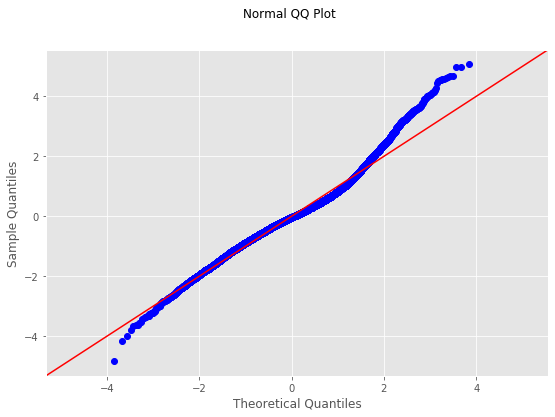

In [39]:
# Plot residual QQ Plot to check normality
with plt.style.context('ggplot'):
    plt.rc("figure", figsize=(9,6))
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.suptitle("Normal QQ Plot")
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Setting data cutoff point to 95% quantile, the right tail is not as fat as compares to the initial model fitting.</li>
        <li>The normality assumption is not violated.
    </ul>
</div>

### 5.6 Homoscedasticity Assumption Check

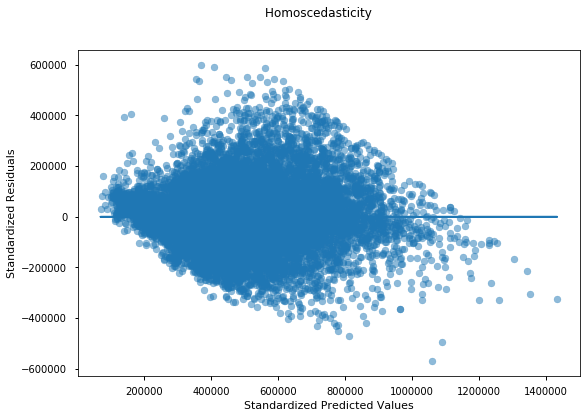

In [40]:
# Plot to show Homoscedasticity
with plt.style.context('seaborn-notebook'):
    plt.rc("figure", figsize=(9,6))
    plt.scatter(model.predict(train_ss[x_cols]), model.resid, alpha=0.5)
    plt.plot(model.predict(train_ss[x_cols]), [0 for i in range(len(train_ss))])
    plt.xlabel('Standardized Predicted Values')
    plt.ylabel('Standardized Residuals')
    plt.suptitle('Homoscedasticity ')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Homoscedastiicity assumptoin holds.</li>
    </ul>
</div>

***

## Alternate Model - Log Transformation (Model B)

### Create New Copy of Dataframe for One-Hot Encoding

In [41]:
# Create a copy of the dataframe
df_log = df.copy()

# Subset data at 99% quantile
df_log = df_log[df_log['price'] < 1970000]
print(f'Percent of data removed:{"{:.2%}".format((len(df) - len(df_log))/len(df))} \n')


Percent of data removed:1.00% 



In [42]:
# Log transform the target variable
df_log['price'] = df_log['price'].map(lambda x: np.log(x))


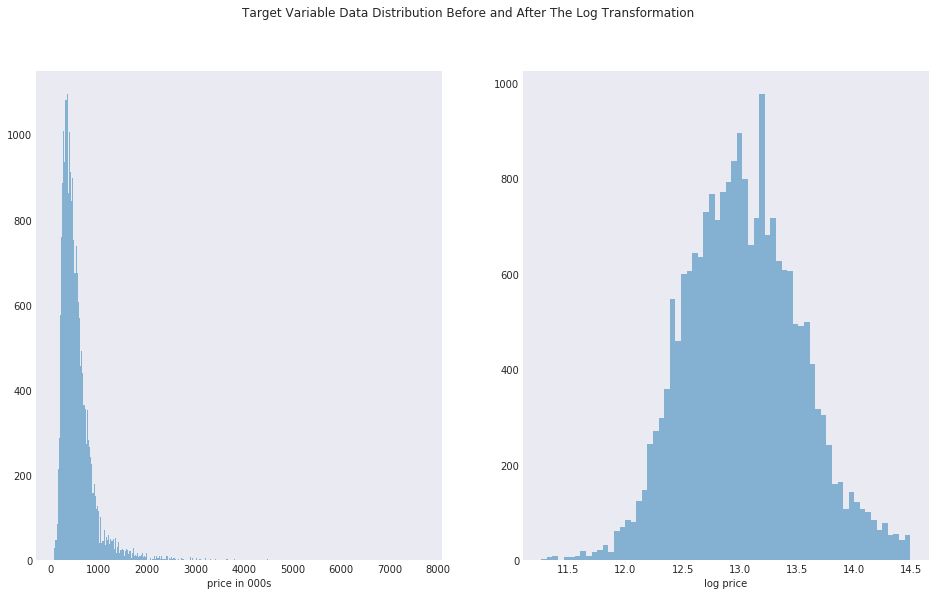

In [43]:
with plt.style.context('seaborn-dark'):
    fig, (ax1, ax2) = plt.subplots(figsize=(16,9), nrows=1, ncols=2, sharey=False)
    ax1.hist(df.price/1000, bins='auto', alpha=0.5)
    ax2.hist(df_log.price, bins='auto', alpha=0.5)
    ax1.set_xlabel('price in 000s')
    ax2.set_xlabel('log price')
    fig.suptitle('Target Variable Data Distribution Before and After The Log Transformation')
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Target variable data distribution closely resembles a normal distribution after the log transformation.</li>
    </ul>
</div>

In [44]:
# Perform one-hot encoding on categorical data
dummies = pd.get_dummies(df_log[nom_cat], prefix=nom_cat, drop_first=True)

# Create a dataframe, dropping nominal feature columns
df_log_cat = df_log.drop(nom_cat, axis=1)

# Concat the above two dataframes
df_log_cat = pd.concat([df_log_cat, dummies], axis=1)

# Preview the results
df_log_cat.head()


,date,price,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,bedrooms_33,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,view_1,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,yr_renovated_1,age_2,age_3,age_4,age_5,city_Bellevue,city_Black Diamond,city_Bothell,city_Carnation,city_Duvall,city_Enumclaw,city_Fall City,city_Federal Way,city_Issaquah,city_Kenmore,city_Kirkland,city_Maple Valley,city_Medina,city_Mercer Island,city_North Bend,city_Redmond,city_Renton,city_Sammamish,city_Seattle,city_Snoqualmie,city_Vashon,city_Woodinville,condition_2,condition_3,condition_4,condition_5,sqft_basement_1
0,10/13/2014,12.309982,1180,5650,1180,1955,98178,47.5112,-122.257,1340,5650,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,6/23/2014,12.232836,880,6780,880,1945,98178,47.5009,-122.248,1190,6780,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,7/17/2014,13.005830,2100,8201,1620,1967,98178,47.5091,-122.244,2660,8712,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
3,9/25/2014,12.371587,1300,5898,1300,1961,98178,47.5053,-122.255,1320,7619,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,2/27/2015,12.043554,860,5265,860,1931,98178,47.5048,-122.272,1650,8775,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


#### Create Train Test Data Set

In [45]:
# Clean up columns name
df_log_cat.columns = [col.replace('.', '_') for col in df_log_cat.columns]
df_log_cat.columns = [col.replace(' ', '_') for col in df_log_cat.columns]

# Create train test datasets
log_train, log_test = train_test_split(df_log_cat, test_size=0.2, random_state=36)

print(log_train.shape, log_test.shape)

(17104, 96) (4276, 96)


### Define Features to Exclude

In [46]:
# Create a list of features to be excluded for the model evaluation

# Exclude date because too many unique values.  May include in refinement if necessary
# Exclude sqft_lot and sqft_lot15 because they lack a linear relationship with the target
# Exclude sqft_above and sqft_living15 because they show strong multicollinearity with sqft_living
# Exclude yr_built because we replaced it with the 'age' column
# Exclude zipcode becasue we map new column 'cities' to zip code
# Exclude condition because there are two rating systems.  Use grade instead

fea_excl = ['date', 'price', 'sqft_lot', 'sqft_above', 'yr_built', 'zipcode',
            'lat', 'long', 'sqft_living15', 'sqft_lot15']        


In [47]:
# Define the problemtr
outcome = 'price'

# Create the feature list
x_cols = list(log_train.columns)

# Remove unwated features
for col in fea_excl:
    x_cols.remove(col)


### Construct the Intial Model

#### Initial Model Fitting

In [48]:
# Model fitting
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=log_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     660.9
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:48   Log-Likelihood:                 148.73
No. Observations:               17104   AIC:                            -125.5
Df Residuals:                   17018   BIC:                             540.8
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.6368      0.303     38.439      0.000      11.043      12.230
sqft_living            0.0002   4.57e-06     42.405      0.000       0.000       0.000
bedrooms_2             0.0218      0.021      1.064      0.287      -0.018       0.062
bedrooms_3             0.0089      0.021      0.431      0.666      -0.031       0.049
bedrooms_4             0.0019      0.021      0.091      0.927      -0.039       0.043
bedrooms_5            -0.0404      0.022     -1.826      0.068      -0.084       0.003
bedrooms_6            -0.0520      0.027     -1.906      0.057      -0.106       0.001
bedrooms_7            -0.1079      0.054     -1.984      0.047      -0.215      -0.001
bedrooms_8             0.0100      0.080      0.125      0.900      -0.146       0.166
bedrooms_9             0.1047      0.123      0.848      0.396      -0.137       0.347
bedrooms_10           -0.1559      0.143     -1.087      0.277      -0.437       0.125
bedrooms_11           -0.3111      0.242     -1.286      0.199      -0.785       0.163
bedrooms_33            0.3747      0.242      1.551      0.121      -0.099       0.848
bathrooms_0_75         0.0916      0.174      0.527      0.598      -0.249       0.432
bathrooms_1_0          0.1477      0.170      0.866      0.386      -0.186       0.482
bathrooms_1_25         0.3963      0.209      1.898      0.058      -0.013       0.806
bathrooms_1_5          0.1618      0.171      0.948      0.343      -0.173       0.496
bathrooms_1_75         0.2035      0.171      1.193      0.233      -0.131       0.538
bathrooms_2_0          0.1969      0.171      1.154      0.248      -0.138       0.531
bathrooms_2_25         0.2182      0.171      1.278      0.201      -0.116       0.553
bathrooms_2_5          0.2131      0.171      1.248      0.212      -0.121       0.548
bathrooms_2_75         0.2377      0.171      1.392      0.164      -0.097       0.573
bathrooms_3_0          0.2331      0.171      1.364      0.173      -0.102       0.568
bathrooms_3_25         0.2551      0.171      1.491      0.136      -0.080       0.590
bathrooms_3_5          0.2399      0.171      1.403      0.161      -0.095       0.575
bathrooms_3_75         0.2952      0.172      1.713      0.087      -0.043       0.633
bathrooms_4_0          0.2348      0.173      1.361      0.174      -0.103       0.573
bathrooms_4_25         0.2570      0.174      1.474      0.141      -0.085       0.599
bathrooms_4_5          0.1893      0.173      1.092      0.275      -0.151       0.529
bathrooms_4_75         0.3142      0.194      1.620      0.105      -0.066       0.694
bathrooms_5_0          0.3116      0.184      1.696      0.090      -0.048       0.672
bathrooms_5_25         0.2335      0.190      1.231      0.218      -0.138       0.605
bathrooms_5_5         -0.0208      0.2

#### Remove P-Value > 0.05 (I)

In [49]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=log_train).fit()
model.summary()


No. of col before: 87. after: 41


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1006.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:49   Log-Likelihood:                -1819.2
No. Observations:               17104   AIC:                             3722.
Df Residuals:                   17062   BIC:                             4048.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.6018      0.024    488.286      0.000      11.555      11.648
sqft_living            0.0003   2.99e-06    113.865      0.000       0.000       0.000
bedrooms_7            -0.2517      0.055     -4.556      0.000      -0.360      -0.143
bathrooms_6_75        -1.2265      0.276     -4.449      0.000      -1.767      -0.686
floors_1_5             0.0085      0.008      1.060      0.289      -0.007       0.024
floors_2_5             0.1282      0.025      5.038      0.000       0.078       0.178
floors_3_0             0.1970      0.013     15.514      0.000       0.172       0.222
waterfront_1           0.3876      0.031     12.621      0.000       0.327       0.448
view_1                 0.1585      0.008     20.576      0.000       0.143       0.174
grade_11               0.0312      0.018      1.747      0.081      -0.004       0.066
grade_12              -0.0911      0.041     -2.208      0.027      -0.172      -0.010
grade_13               0.6330      0.270      2.347      0.019       0.104       1.162
yr_renovated_1         0.0735      0.012      6.179      0.000       0.050       0.097
age_2                  0.0269      0.006      4.490      0.000       0.015       0.039
age_3                 -0.0731      0.006    -12.088      0.000      -0.085      -0.061
age_4                  0.1564      0.009     17.857      0.000       0.139       0.174
age_5                  0.1824      0.009     19.699      0.000       0.164       0.200
city_Bellevue          0.7765      0.011     69.238      0.000       0.754       0.798
city_Black_Diamond     0.2280      0.031      7.429      0.000       0.168       0.288
city_Bothell           0.4332      0.016     27.665      0.000       0.403       0.464
city_Carnation         0.2748      0.029      9.540      0.000       0.218       0.331
city_Duvall            0.3142      0.023     13.456      0.000       0.268       0.360
city_Enumclaw          0.0296      0.021      1.433      0.152      -0.011       0.070
city_Fall_City         0.4055      0.034     11.920      0.000       0.339       0.472
city_Issaquah          0.5888      0.012     49.644      0.000       0.566       0.612
city_Kenmore           0.0541      0.011      4.738      0.000       0.032       0.076
city_Kirkland          0.5454      0.015     35.984      0.000       0.516       0.575
city_Maple_Valley      0.1698      0.014     11.846      0.000       0.142       0.198
city_Medina            1.2960      0.062     20.785      0.000       1.174       1.418
city_Mercer_Island     0.9249      0.020     45.707      0.000       0.885       0.965
city_North_Bend        0.3483      0.022     16.124      0.000       0.306       0.391
city_Redmond           0.6953      0.011     63.468      0.000       0.674       0.717
city_Renton            0.2445      0.0

#### Remove P-Value > 0.05 (II)

In [50]:
# Refit model with subset features by removing features with p-values that are greater than 0.05
bef_cols, aft_cols, x_cols = myf.refine_xcols(model.summary())
print(f'No. of col before: {bef_cols}. after: {aft_cols}')
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=log_train).fit()
model.summary()


No. of col before: 42. after: 37


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     1114.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:49   Log-Likelihood:                -1822.4
No. Observations:               17104   AIC:                             3721.
Df Residuals:                   17066   BIC:                             4015.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.6027      0.024    492.382      0.000      11.556      11.649
sqft_living            0.0003   2.76e-06    124.207      0.000       0.000       0.000
bedrooms_7            -0.2530      0.055     -4.581      0.000      -0.361      -0.145
bathrooms_6_75        -1.2045      0.275     -4.375      0.000      -1.744      -0.665
floors_2_5             0.1271      0.025      5.004      0.000       0.077       0.177
floors_3_0             0.1965      0.013     15.580      0.000       0.172       0.221
waterfront_1           0.3861      0.031     12.579      0.000       0.326       0.446
view_1                 0.1599      0.008     20.934      0.000       0.145       0.175
grade_12              -0.0982      0.041     -2.390      0.017      -0.179      -0.018
grade_13               0.6266      0.270      2.323      0.020       0.098       1.155
yr_renovated_1         0.0728      0.012      6.128      0.000       0.050       0.096
age_2                  0.0271      0.006      4.534      0.000       0.015       0.039
age_3                 -0.0732      0.006    -12.320      0.000      -0.085      -0.062
age_4                  0.1597      0.008     19.117      0.000       0.143       0.176
age_5                  0.1854      0.009     20.843      0.000       0.168       0.203
city_Bellevue          0.7735      0.011     71.050      0.000       0.752       0.795
city_Black_Diamond     0.2245      0.031      7.345      0.000       0.165       0.284
city_Bothell           0.4292      0.015     27.799      0.000       0.399       0.460
city_Carnation         0.2728      0.029      9.516      0.000       0.217       0.329
city_Duvall            0.3100      0.023     13.360      0.000       0.264       0.355
city_Fall_City         0.4022      0.034     11.861      0.000       0.336       0.469
city_Issaquah          0.5851      0.012     50.557      0.000       0.562       0.608
city_Kenmore           0.0502      0.011      4.520      0.000       0.028       0.072
city_Kirkland          0.5426      0.015     36.341      0.000       0.513       0.572
city_Maple_Valley      0.1652      0.014     11.735      0.000       0.138       0.193
city_Medina            1.2918      0.062     20.738      0.000       1.170       1.414
city_Mercer_Island     0.9221      0.020     46.004      0.000       0.883       0.961
city_North_Bend        0.3440      0.021     16.048      0.000       0.302       0.386
city_Redmond           0.6915      0.011     64.975      0.000       0.671       0.712
city_Renton            0.2408      0.010     23.515      0.000       0.221       0.261
city_Sammamish         0.5934      0.016     36.624      0.000       0.562       0.625
city_Seattle           0.4778      0.008     58.764      0.000       0.462       0.494
city_Snoqualmie        0.3652      0.0

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Initial results seem promising as the model produces a high $R^{2}$ score of 0.707.</li>
        <li>The model Skew and Kurtosis values are within the acceptable range.</li>
    </ul>
</div>

### Multicollinearity Check

In [51]:
# Investigate multicollinearity
x_cols, vif = myf.cal_vif(log_train, x_cols, variance_inflation_factor)
list(zip(x_cols, vif))


[('sqft_living', 8.674278149522165),
 ('bedrooms_7', 1.0501537015156404),
 ('bathrooms_6_75', 1.0438304317572864),
 ('floors_2_5', 1.0222738106904414),
 ('floors_3_0', 1.1127691242051736),
 ('waterfront_1', 1.0899002520239593),
 ('view_1', 1.2883219076092773),
 ('grade_12', 1.0445955481802929),
 ('grade_13', 1.0016954265680764),
 ('yr_renovated_1', 1.1036208793407054),
 ('age_2', 1.7482372670472952),
 ('age_3', 1.8593712320676343),
 ('age_4', 1.3403574551688315),
 ('age_5', 1.3187386894781499),
 ('city_Bellevue', 1.7213633008235114),
 ('city_Black_Diamond', 1.05161225600202),
 ('city_Bothell', 1.2370315075400315),
 ('city_Carnation', 1.0566858435885844),
 ('city_Duvall', 1.096720540554228),
 ('city_Fall_City', 1.0416232376235295),
 ('city_Issaquah', 1.5807387074872166),
 ('city_Kenmore', 1.5755607444250328),
 ('city_Kirkland', 1.2723243050047923),
 ('city_Maple_Valley', 1.3195655772303305),
 ('city_Medina', 1.0146758468782795),
 ('city_Mercer_Island', 1.165453565057461),
 ('city_North_

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Condition_3 is the only feature that show strong multicollinearity.</li>
    </ul>
</div>

### Normality Assumption Check

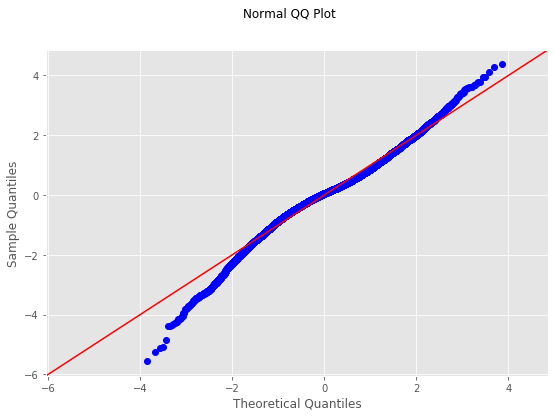

In [52]:
# Plot residual QQ Plot to check normality 
with plt.style.context('ggplot'):
    plt.rc("figure", figsize=(9,6))
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.suptitle("Normal QQ Plot")
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Normality assumption hold.</li>
    </ul>
</div>

### Homoscedasticity Assumption Check

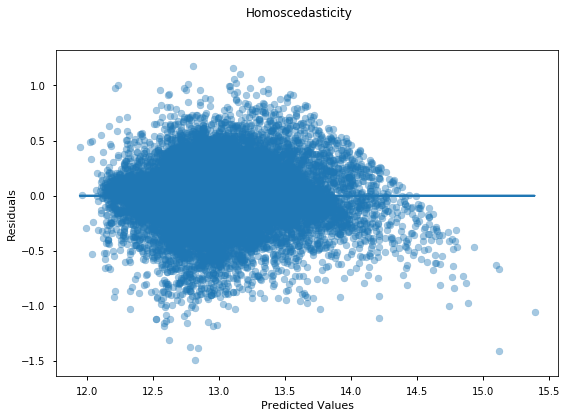

In [53]:
# Plot to show Homoscedasticity
with plt.style.context('seaborn-notebook'):
    plt.rc("figure", figsize=(9,6))
    plt.scatter(model.predict(log_train[x_cols]), model.resid, alpha=0.4)
    plt.plot(model.predict(log_train[x_cols]), [0 for i in range(len(log_train))])
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.suptitle('Homoscedasticity')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The plot shows no obvious cone shape pattern overall.</li>
    </ul>
</div>

### Model B - Model Refinement

#### Remove Offending VIF

In [54]:
# remove VIF greater than 5 except sqft_living
x_cols = myf.rem_large_vif(x_cols, vif, 10, np)
print(x_cols)
len(x_cols)


['sqft_living', 'bedrooms_7', 'bathrooms_6_75', 'floors_2_5', 'floors_3_0', 'waterfront_1', 'view_1', 'grade_12', 'grade_13', 'yr_renovated_1', 'age_2', 'age_3', 'age_4', 'age_5', 'city_Bellevue', 'city_Black_Diamond', 'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Fall_City', 'city_Issaquah', 'city_Kenmore', 'city_Kirkland', 'city_Maple_Valley', 'city_Medina', 'city_Mercer_Island', 'city_North_Bend', 'city_Redmond', 'city_Renton', 'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon', 'city_Woodinville', 'condition_4', 'condition_5']


36

#### Refit Model with Updates

In [55]:
# Refit model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=log_train).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1134.
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:52:52   Log-Likelihood:                -1883.4
No. Observations:               17104   AIC:                             3841.
Df Residuals:                   17067   BIC:                             4127.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.8411      0.010   1243.853      0.000      11.822      11.860
sqft_living            0.0003   2.76e-06    124.663      0.000       0.000       0.000
bedrooms_7            -0.2527      0.055     -4.558      0.000      -0.361      -0.144
bathrooms_6_75        -1.2120      0.276     -4.387      0.000      -1.754      -0.670
floors_2_5             0.1290      0.025      5.061      0.000       0.079       0.179
floors_3_0             0.1999      0.013     15.797      0.000       0.175       0.225
waterfront_1           0.3851      0.031     12.503      0.000       0.325       0.446
view_1                 0.1600      0.008     20.863      0.000       0.145       0.175
grade_12              -0.1010      0.041     -2.451      0.014      -0.182      -0.020
grade_13               0.6254      0.271      2.311      0.021       0.095       1.156
yr_renovated_1         0.0761      0.012      6.385      0.000       0.053       0.099
age_2                  0.0283      0.006      4.710      0.000       0.017       0.040
age_3                 -0.0744      0.006    -12.485      0.000      -0.086      -0.063
age_4                  0.1561      0.008     18.629      0.000       0.140       0.172
age_5                  0.1801      0.009     20.208      0.000       0.163       0.198
city_Bellevue          0.7732      0.011     70.770      0.000       0.752       0.795
city_Black_Diamond     0.2265      0.031      7.385      0.000       0.166       0.287
city_Bothell           0.4310      0.015     27.816      0.000       0.401       0.461
city_Carnation         0.2682      0.029      9.324      0.000       0.212       0.325
city_Duvall            0.3118      0.023     13.391      0.000       0.266       0.357
city_Fall_City         0.4016      0.034     11.802      0.000       0.335       0.468
city_Issaquah          0.5866      0.012     50.505      0.000       0.564       0.609
city_Kenmore           0.0515      0.011      4.617      0.000       0.030       0.073
city_Kirkland          0.5450      0.015     36.372      0.000       0.516       0.574
city_Maple_Valley      0.1681      0.014     11.902      0.000       0.140       0.196
city_Medina            1.2919      0.063     20.667      0.000       1.169       1.414
city_Mercer_Island     0.9192      0.020     45.703      0.000       0.880       0.959
city_North_Bend        0.3433      0.022     15.959      0.000       0.301       0.385
city_Redmond           0.6923      0.011     64.815      0.000       0.671       0.713
city_Renton            0.2411      0.010     23.458      0.000       0.221       0.261
city_Sammamish         0.5940      0.016     36.529      0.000       0.562       0.626
city_Seattle           0.4791      0.008     58.725      0.000       0.463       0.495
city_Snoqualmie        0.3664      0.0

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>After removing condition_3, the $R^{2}$ drops very slightly, from 0.707 to 7.05.</li>
    </ul>
</div>

### Multicollinearity Assumption Check

In [56]:
# Investigate multicollinearity
x_cols, vif = myf.cal_vif(log_train, x_cols, variance_inflation_factor)
list(zip(x_cols, vif))


[('sqft_living', 6.087270178980587),
 ('bedrooms_7', 1.0489334390175191),
 ('bathrooms_6_75', 1.0434810403291024),
 ('floors_2_5', 1.021984953191151),
 ('floors_3_0', 1.107745170243174),
 ('waterfront_1', 1.0899002418556785),
 ('view_1', 1.2779415170774253),
 ('grade_12', 1.0374381085083666),
 ('grade_13', 1.001586321836995),
 ('yr_renovated_1', 1.1029942875283516),
 ('age_2', 1.6358709800791722),
 ('age_3', 1.7249501490208137),
 ('age_4', 1.3335819988739157),
 ('age_5', 1.3137486561908749),
 ('city_Bellevue', 1.5148338246555948),
 ('city_Black_Diamond', 1.0296825001412007),
 ('city_Bothell', 1.1304051150799457),
 ('city_Carnation', 1.033260594440329),
 ('city_Duvall', 1.049299132726863),
 ('city_Fall_City', 1.0253814534129868),
 ('city_Issaquah', 1.3776647684189463),
 ('city_Kenmore', 1.3045668714491951),
 ('city_Kirkland', 1.158520757513007),
 ('city_Maple_Valley', 1.1580832798011516),
 ('city_Medina', 1.0116010423359219),
 ('city_Mercer_Island', 1.1395233174440904),
 ('city_North_Be

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>No multicollinearity reported.</li>
        <li>Sqft_living VIF value drops to 6.087 from 8.674.  One can conclude that there is a correlation between sqft_living and condition_3 because most houses in the sample are rated with condition_3.</li>
    </ul>
</div>

### Normality Check

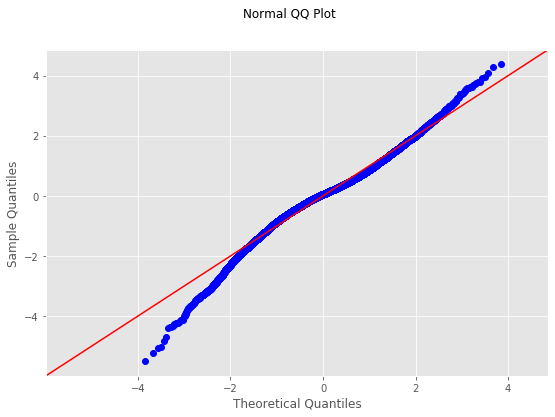

In [57]:
# Plot residual QQ plot to check normality
with plt.style.context('ggplot'):
    plt.rc("figure", figsize=(9,6))
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    fig.suptitle("Normal QQ Plot")
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Normality certainly holds for majority of the data points.  Outliers still account for the slight upper right tail and left lower tail.</li>
    </ul>
</div>

### Homoscedasticity Check

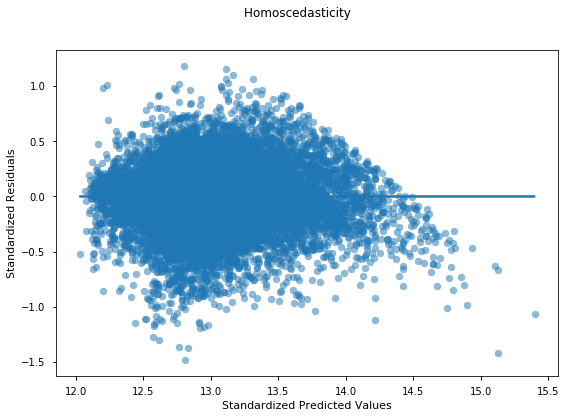

In [58]:
# Plot to show Homoscedasticity
with plt.style.context('seaborn-notebook'):
    plt.rc("figure", figsize=(9,6))
    plt.scatter(model.predict(log_train[x_cols]), model.resid, alpha=0.5)
    plt.plot(model.predict(log_train[x_cols]), [0 for i in range(len(log_train))])
    plt.xlabel('Standardized Predicted Values')
    plt.ylabel('Standardized Residuals')
    plt.suptitle('Homoscedasticity ')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Homoscedasticity does not seem to be violated.</li>
    </ul>       
</div>

***

## Model Interpretation

### Models Comparisons

<div class="alert alert-info">
<b>Observations</b>
    <ul>
        <li>Model A contructed in section 1.6 was built from the ground up by analyzing the data. There were no data transformation or standardization involved.</li>
        <li>Model B was built according to the steps taken in Model A, except we log transformed the target variable.</li>
        <li>Model B has a higher $R^{2}$, 0.705 vs Model A 0.685.  This could be attributed to the sample size used in both models.  To ensure that Model A adheres to the normality assumption, we have to remove outliers from the sample.  On the other hand, due to log transformation, we could afford to use 99% of the data in Model B.</li>
        <li>Based on the $R^{2}$ performance, we will continue the model interpretaion uisng Model B.</li>
    </ul>       
</div>

### Model Validation

#### Comparing $R^{2}$ Between Train and Test Sets

In [59]:
# Calculate R2 for both train and test
from sklearn.metrics import r2_score

train_r2 = r2_score(log_train['price'], model.predict(log_train))
print(f'train r2 = {round(train_r2,3)}')

test_r2 = r2_score(log_test['price'], model.predict(log_test))
print(f'test r2 = {round(test_r2,3)}')


train r2 = 0.705
test r2 = 0.703


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There is a difference of 0.2837%  between the train and test $R^{2}$.</li>
        <li>The model does not appear to be over or under fitted.</li>    
    </ul>
</div>

### Model Coefficient Interpretations

#### Sqft_living Coefficient

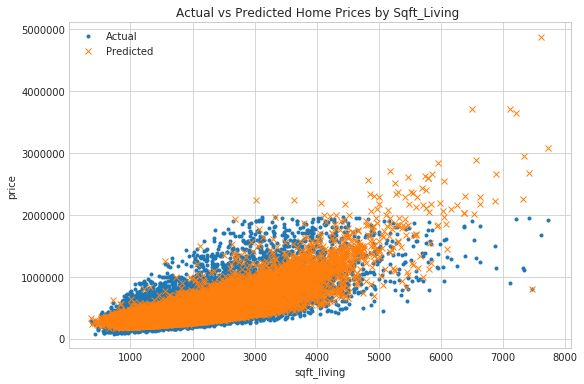

In [60]:
# Plot the relationship between predicted vs actual price
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9,6))
    plt.plot(log_train.sqft_living, np.exp(log_train.price), '.', label='Actual')
    plt.plot(log_train.sqft_living, np.exp(model.predict(log_train)), 'x', label='Predicted')
    plt.xlabel('sqft_living')
    plt.ylabel('price')
    plt.legend()
    plt.title("Actual vs Predicted Home Prices by Sqft_Living ")


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Sqft_Living has a 0.0003 coefficient.  Transforming it back to decimal [(np.exp(0.0003)-1)*100], which is approximately 0.03%.  Thus, for 1 unit of increase in sqft_living, home prices will increase by 0.03%. To round up the percent increase, we can say that for every 100 units increase in sqft_living, home prices increase by 3%</li>
        <li>The plot above shows the prediction power of the model.  Blue dots not covered by the orange markers are the 30% which our model could not explain.</li>
        <li>The model performs poorly on outliers since we did not include the top 1% in our model.</li>
        <li><p>Recommendations:</p> As long as the costs of increase sqft_living is lower than the potential gain in the home values after the increase living spaces, sellers should consider the idea of remodeling the house.</li>
    </ul>
</div>

#### City Coefficient

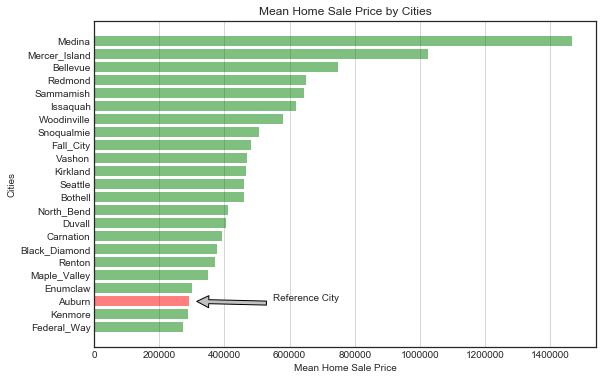

In [61]:
# Extract referrence dummies variable
c_au = np.log(df[df['city'] == 'Auburn']['price'].mean())

# Extract mean price from each city
v_cities = [col for col in log_train.columns if 'city_' in col]
city_dic = []
for city in v_cities:
    city_dic.append({'city': city.replace('city_', ''), 'price': log_train[log_train[city] == 1]['price'].mean()})
  
city_dic.append({'city': 'Auburn', 'price':c_au})

df_city = pd.DataFrame(sorted(city_dic, key=lambda x: x['price']))
df_city['price_t'] = df_city['price'].map(lambda x: np.exp(x))
df_city.head()

# Plot Mean Home price by City
with plt.style.context('seaborn-white'):
    plt.rc("figure", figsize=(9,6))
    color = [ 'g' for i in list(df_city['city'])]
    color[(list(df_city['city'])).index('Auburn')] = 'red'
    ax = plt.barh('city', 'price_t', data=df_city, color=color, alpha=0.5)
    plt.annotate('Reference City', xy =(300000, 'Auburn'), 
                xytext =(550000, 'Auburn'),  
                arrowprops = dict(facecolor ='silver', 
                                  shrink = 0.06)) 
    plt.grid(axis='x')
    plt.xlabel('Mean Home Sale Price')
    plt.ylabel('Cities')
    plt.title('Mean Home Sale Price by Cities')
    plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>Among the statistical significance cities, Medina comes up at the top of the chart.  It has a 1.2919 coefficient.  As such, houses in Medina would cost approximately 263.97%  more than those in Auburn.  The mean home price is so much higher than the rest is because 85% of the houses in Medina fall above the 95% quantile.  As a side note, both Bill Gate and Jeff Bezos live in Medina.</li>
        <li>The second top city Mercer_Island has a coefficient of 0.9192 which translates to a locality premium of around 150.73% over houses in Auburn.</li>
        <li>Houses in the third top city Bellevue, with a coefficient of 0.7732, costs 116.67% more than those houses in Auburn.</li>
        <li><p>Recommendations:</p>Baed on above analysis, sellers ought to take into account the location of their homes and price their properties accordingly.  From the buyers point of view, it might not be an unwise decision to pay for the location premium since the home resale value can save more money in the long run.</li>
    </ul>    
</div>

#### Grade Coeficient

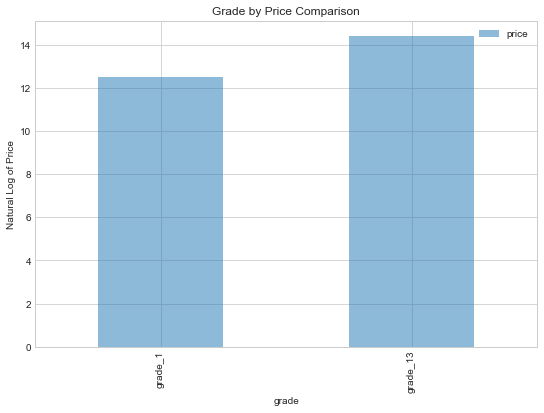

In [62]:
# Extract referrence dummies variable
g_1_p = np.log(d.iloc[3220,:]['price'])

# Create dataframe to house comparison data
g_13_p = log_train[log_train['grade_13'] == 1]['price'].values[0]
grd = pd.DataFrame([{'grade':'grade_1','price': g_1_p},{'grade':'grade_13','price': g_13_p}])
grd['price_t'] = grd['price'].map(lambda x: np.exp(x))
grd.reset_index()

with plt.style.context('seaborn-whitegrid'):
    grd.plot.bar('grade', 'price', alpha=0.5, figsize=(9,6))
    plt.ylabel('Natural Log of Price')
    plt.title('Grade by Price Comparison')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>There are 11 grades in the dataset. Grade 13 being the highest or best grade.</li>
        <li>The model reports back a coefficient of 0.6254 for grade_13.  After transforming, it is roughly 86.89%.  Meaning that houses rated at grade 13, generally cost 89.89% more than houses graded 1.  Houses with higher grade mean better building quality which cost more to build.</li>
        <li>The plot above show the difference in home prices between a grade_1 house and a grade_13 house.</li>
        <li><p>Recommendations:</p>Instead of putting the money into home renovation to boost house values, once can choose the alternate route by allocating funds in maintaining the home, such as replacing drafty windows, caulking the tiles, or a new paint job for the home. </li>
    </ul>
</div>

#### Waterfront Coefficient

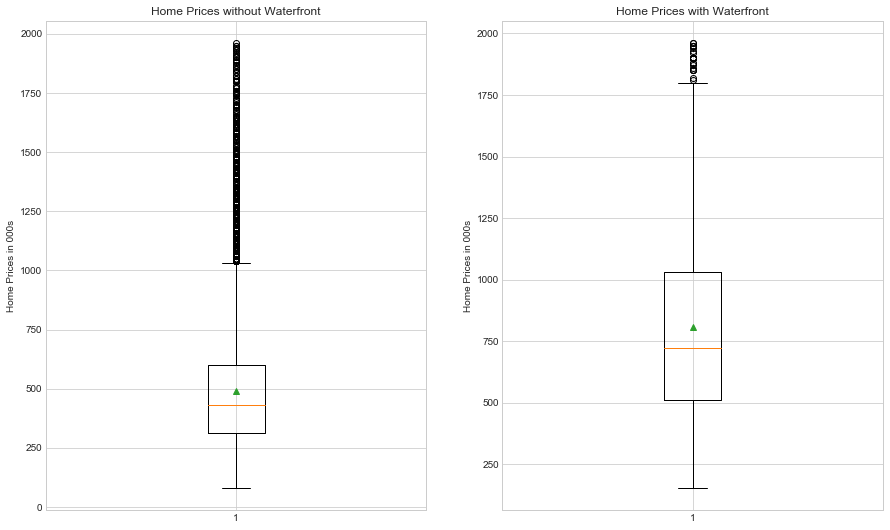

In [63]:
# Plot data distribution on house with and without waterfront 
x_ax1 = np.exp(log_train[log_train['view_1'] == 0]['price'])/1000
x_ax2 = np.exp(log_train[log_train['view_1'] == 1]['price'])/1000

with plt.style.context('seaborn-whitegrid'):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 9))
    ax1.boxplot(x_ax1, showmeans=True)
    ax1.set_ylabel('Home Prices in 000s')
    ax1.set_title('Home Prices without Waterfront')
    ax2.boxplot(x_ax2, showmeans=True)
    ax2.set_ylabel('Home Prices in 000s')
    ax2.set_title('Home Prices with Waterfront')
    plt.show()
    

<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>The box plot paints a clear picture that houses by the waterfront cost more than those without one.</li>
        <li>The waterfront_1's coefficient of 0.3851 translates to a 46.97% more expensive for waterfront houses than those not by the water.</li>
        <li><p>Recommendations:</p>With the high premium for the waterfornt homes, it might seem like a sound investment.  However, one should not igonre the flooding  factor where the house is situated.  In addition, one should understand the town ordinances regarding waterfront houses before taking the plunge in buying a waterfront property.</li>
    </ul>
</div>

#### Floor Coefficient

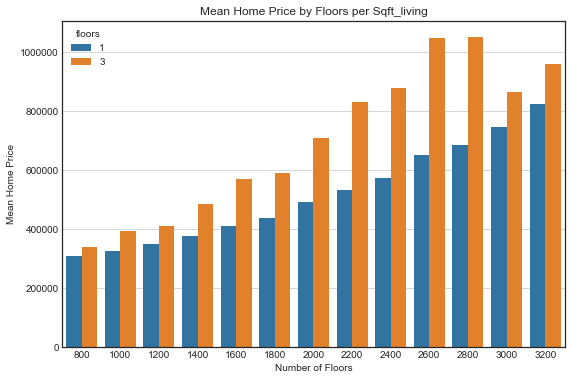

In [64]:
# Extract floors data
flr_1 = df_log[df_log['floors'] == 1.0][['price', 'sqft_living']]
flr_3 = log_train[log_train['floors_3_0'] == 1][['price', 'sqft_living']]

# Transform price back to decimal
flr_1['price'] = flr_1['price'].apply(lambda x: np.exp(x))
flr_3['price'] = flr_3['price'].apply(lambda x: np.exp(x))

# Get mean price per sqft_living in interval of 200 increment
flr_dic = []
for i in range(800, 3400, 200):
    flr1 = flr_1[(flr_1['sqft_living'] > i) & (flr_1['sqft_living'] <= i+200)].mean()
    flr_dic.append({'price': flr1[0], 'sqft_living': i, 'floors': 1})
    flr3 = flr_3[(flr_3['sqft_living'] > i) & (flr_3['sqft_living'] <= i+200)].mean()
    flr_dic.append({'price': flr3[0], 'sqft_living': i, 'floors': 3})
    
# Convert list to dataframe
df_flr = pd.DataFrame(flr_dic)

# Plot Conmparison
with plt.style.context('seaborn-white'):
    plt.rc("figure", figsize=(9,6))
    sns.barplot(x='sqft_living', y='price', data=df_flr, hue="floors")
    plt.grid(axis='y')
    plt.xlabel('Number of Floors')
    plt.ylabel('Mean Home Price')
    plt.title('Mean Home Price by Floors per Sqft_living')
    plt.show()


<div class="alert alert-block alert-info">
<b>Observations</b>
    <ul>
        <li>According to the model, houses with 3 floors in general cost 22.13% more than single story houses.</li>
        <li>The plot above compares the mean price between single story home and houses with three floors with similar sqft_living.</li>
        <li><p>Recommendations:</p>Home owners with squared foot living under 1800 sqft might want to consider adding additional floor(s) to the existing structure because these additional living spaces translate to higher home sale prices.  Diminishing return steps in if the single story homes already have a squared foot living of more than 2800 sqft.</li>
    </ul>
</div>

***

## Conclusion

<p><b>Firstly, all the assumptions for a regression model have been checked and verified.  Therefore, we are quite confident with the 70% predicting power of the model.  Moreover, the model performs well with the train and test data sets, signaling that it should be adequate to predict new data.</b></p>

<p><b>Secondly, home sellers can rely on the most influential features in the model to make sound decision with regard to which areas to improve their home to fetch a higher home sale price.  For instance, sellers can boost the county grading by making general repairs and improvements to their home or they can undertake major remodeling by adding more living spaces and adding additional floors.  All these actions will result in a higher home values, according to our business model.  Furthermore, the model includes enough features, 37 total, to suit sellers with different budgets and criteria, for which they can undertake to improve their home values.</b></p>
<p><b>Thirdly, as for the home buyers, they can leverage the model to determine a fair market value for the property they are interested in investing.  </b></p> 
<p><b>Lastly, one caveat here is that the model will not perform well for predicting houses over 2.0 million dollars, because we did not account for such variation in our model.  Perhaps, a separate model tailored to predicting expensive houses might be warranted.</b><p>   
   

***